In [1]:
# Imports and configuration
%load_ext autoreload
%autoreload 2

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score
import src.helpers.model_helpers as mh
from scipy.stats import randint, loguniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight

In [2]:
# Load modeling dataset and the split indices
X_train, y_train, X_test, y_test = mh.load_model_dataset()

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/processed/hmda_2024_model.parquet


In [15]:
# Create and train model
base_hgbm = HistGradientBoostingClassifier(random_state=42, early_stopping=True, validation_fraction=0.1, n_iter_no_change=30)
param_grid = {
    "learning_rate": loguniform(1e-3, 1e-1),
    "max_iter": randint(400, 1500),
    "max_depth": [2, 3, 4],
    "max_leaf_nodes": randint(16, 96),
    "min_samples_leaf": randint(100, 600),
    "l2_regularization": loguniform(1e-4, 10),
    "max_bins": randint(64, 255),
}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

search = RandomizedSearchCV(
    estimator=base_hgbm,
    param_distributions=param_grid,
    n_iter=40,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True
)

search.fit(X_train, y_train, sample_weight=weight_train)

,estimator,HistGradientB...ndom_state=42)
,param_distributions,"{'l2_regularization': <scipy.stats....t 0x12b1e3770>, 'learning_rate': <scipy.stats....t 0x12a211e00>, 'max_bins': <scipy.stats....t 0x12b1ad7c0>, 'max_depth': [2, 3, ...], ...}"
,n_iter,40
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [21]:
# Calculate F1 for validation
mh.output_cv_summary(search)

Best params: {'l2_regularization': np.float64(0.06403036652671171), 'learning_rate': np.float64(0.03482846706526884), 'max_bins': 166, 'max_depth': 4, 'max_iter': 792, 'max_leaf_nodes': 94, 'min_samples_leaf': 114}
Best CV F1: 0.7791292927383713


In [22]:
# Calculate metrics
results, y_pred, y_prob = mh.calculate_test_metrics(search, X_test, y_test)

# Save metrics to CSV
mh.save_metrics_to_csv(results, "hgbm_metrics_csv")

# Display metrics
print("Test Performance:")
display(results)

Test Performance:


,Score
F1,0.655835
Accuracy,0.808325
Precision,0.575024
Recall,0.763075
ROC AUC,0.872487
PR AUC,0.744717


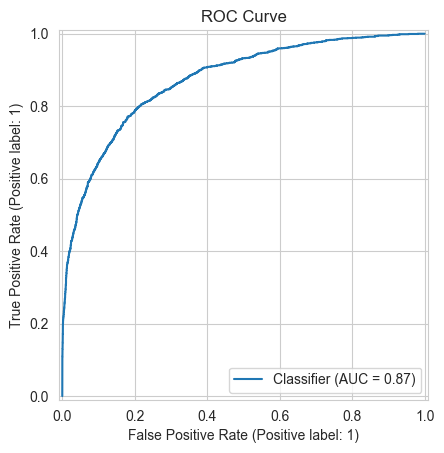

In [18]:
# ROC Curve
mh.draw_roc_curve(y_test, y_prob, "hgbm_roc")

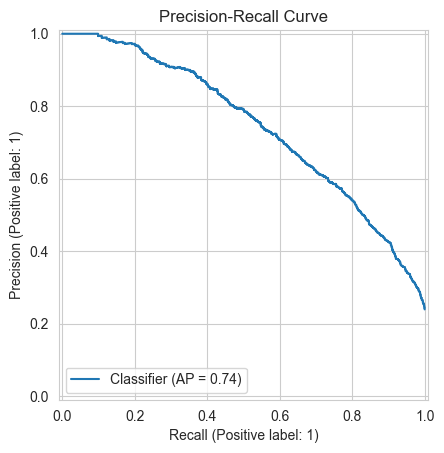

In [19]:
# PR Curve
mh.draw_pr_curve(y_test, y_prob, "hgbm_pr")

In [20]:
# Persist fitted model
mh.persist_model(search, "hgbm_model")